This notebook shows the functions provided by TINC to create parameter spaces and data pools from configuration and output files. There are two methods:

  * Using the output data
  * Using configuration files
  
Using the output can be very convenient as you can create a DataPool automatically to explore the data, but there are cases where you might need to extract the parameter space from configuration files instead, in cases where the parameters are not present in the output data.

In [1]:
from tinc import *
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
%pylab inline
%matplotlib widget

Populating the interactive namespace from numpy and matplotlib


/home/jonnyli/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['unique', 'interactive']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
#Load  tinc data pools for the separate heating and cooling grids in T vs chempot space
user="jonny"
if(user=="jonny"):
    print("using Jonny's paths")
    heating_data_dir = "/home/jonnyli/Desktop/CASM/experiments/ZrN_FCC_1.2.0_demo/mc_coarse_new_scel/heating"
    cooling_data_dir = "/home/jonnyli/Desktop/CASM/experiments/ZrN_FCC_1.2.0_demo/mc_coarse_new_scel/cooling"
else:
    print("using Derick's paths")
    heating_data_dir = "/media/derick/DeoResearch/experiments/ZrN_FCC_1.2.0_demo/mc_coarse_new_scel/heating"
    cooling_data_dir = "/media/derick/DeoResearch/experiments/ZrN_FCC_1.2.0_demo/mc_coarse_new_scel/cooling"
heating_dp, heating_ps  = create_datapool_from_output(heating_data_dir, "results.json", ignore_params=['Beta'])
cooling_dp, cooling_ps = create_datapool_from_output(cooling_data_dir, "results.json", ignore_params=['Beta'])

using Jonny's paths
Found more than one potential parameter in files:['Beta', 'T'] 
Using:T 
Found more than one potential parameter in files:['Beta', 'T'] 
Using:T 


In [3]:
heating_dp.get_slice("integ_grand_free_energy", "param_chem_pot(a)")
cooling_dp.get_slice("integ_grand_free_energy", "param_chem_pot(a)")
#dp.get_slice("<comp_n(N)>", "T")


masked_array(data=[ 3.7538629e-02,  3.7411947e-02,  3.7268307e-02,
                    3.7096158e-02,  3.6900580e-02,  3.6666315e-02,
                    3.6398679e-02,  3.6083251e-02,  3.5722330e-02,
                    3.5291769e-02,  3.4795910e-02,  3.4211397e-02,
                    3.3534102e-02,  3.2730497e-02,  3.1792656e-02,
                    3.0685818e-02,  2.9381581e-02,  2.7847877e-02,
                    2.6039608e-02,  2.3902917e-02,  2.1389842e-02,
                    1.8424008e-02,  1.4936008e-02,  1.0837190e-02,
                    6.0306857e-03,  4.2946354e-04, -6.0630576e-03,
                   -1.3496105e-02, -2.1884905e-02, -3.1212978e-02,
                   -4.1387841e-02, -5.2349430e-02, -6.4032316e-02,
                   -7.6353125e-02, -8.9274406e-02, -1.0272570e-01,
                   -1.1666850e-01, -1.3106889e-01, -1.4590499e-01,
                   -1.6113611e-01, -1.7674707e-01, -1.9272780e-01,
                   -2.0906168e-01, -2.2571935e-01, -2.4270289e

In [4]:
#Create meshgrid of chemical potential and temperature
heating_chempot_grid, heating_temperature_grid = np.meshgrid(heating_ps.get_dimension('param_chem_pot(a)').values, heating_ps.get_dimension("T").values)
print(heating_chempot_grid)
print(heating_temperature_grid)

#Initialize integrated free energy grid
heating_integrated_free_energy = np.zeros(heating_chempot_grid.shape)
print(heating_integrated_free_energy.shape)


#Same for cooling
cooling_chempot_grid, cooling_temperature_grid = np.meshgrid(cooling_ps.get_dimension("param_chem_pot(a)").values, cooling_ps.get_dimension("T").values)
cooling_integrated_free_energy = np.zeros(cooling_chempot_grid.shape)


[[-1.    -0.975 -0.95  ...  0.95   0.975  1.   ]
 [-1.    -0.975 -0.95  ...  0.95   0.975  1.   ]
 [-1.    -0.975 -0.95  ...  0.95   0.975  1.   ]
 ...
 [-1.    -0.975 -0.95  ...  0.95   0.975  1.   ]
 [-1.    -0.975 -0.95  ...  0.95   0.975  1.   ]
 [-1.    -0.975 -0.95  ...  0.95   0.975  1.   ]]
[[  20.   20.   20. ...   20.   20.   20.]
 [  40.   40.   40. ...   40.   40.   40.]
 [  60.   60.   60. ...   60.   60.   60.]
 ...
 [1960. 1960. 1960. ... 1960. 1960. 1960.]
 [1980. 1980. 1980. ... 1980. 1980. 1980.]
 [2000. 2000. 2000. ... 2000. 2000. 2000.]]
(100, 81)


In [5]:
[i.id for i in heating_ps.get_dimensions()]

['T', 'param_chem_pot(a)']

In [6]:
for value in heating_ps.get_dimension("param_chem_pot(a)").values:
    
    #Set the current value of the tinc parameter "param_chem_pot(a)" to "value" 
    heating_ps.get_parameter("param_chem_pot(a)").value = value
    
    #Slice integrated grand canonical free energy vs T for the fixed chemical potential
    tmp_heating_integ_free_energy = heating_dp.get_slice("integ_grand_free_energy","T")

    #Find the index of the current chemical potential in the vetor of chemical potential values (held by the tinc parameter "param_chem_pot(a)")
    chempot_index = heating_ps.get_dimension("param_chem_pot(a)").values.index(value)

    #fill in the integrated grand canonical free energy grid for fixed chemical potential
    heating_integrated_free_energy[:,chempot_index] = tmp_heating_integ_free_energy


#Same for the cooling free energy surface. 
for value in cooling_ps.get_dimension("param_chem_pot(a)").values:
    
    cooling_ps.get_parameter("param_chem_pot(a)").value = value
    
    tmp_cooling_integ_free_energy = cooling_dp.get_slice("integ_grand_free_energy","T")

    chempot_index = cooling_ps.get_dimension("param_chem_pot(a)").values.index(value)

    cooling_integrated_free_energy[:,chempot_index] = tmp_cooling_integ_free_energy


<ipython-input-7-7eb90b866dd6>:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Text(0.5, 0, 'Integrated Free Energy (eV)')

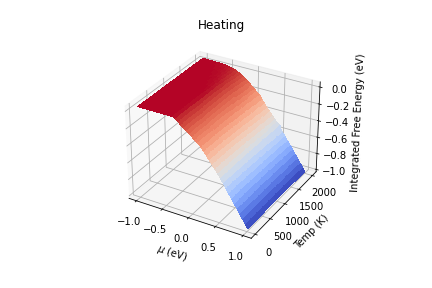

In [7]:
#plot the heating free energy surfaces:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(heating_chempot_grid, heating_temperature_grid, heating_integrated_free_energy, cmap=cm.coolwarm,linewidth=1, antialiased=False)
ax.set_title("Heating")
ax.set_xlabel("$\mu$ (eV)")
ax.set_ylabel("Temp (K)")
ax.set_zlabel("Integrated Free Energy (eV)")


<ipython-input-8-79f297e5491f>:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Text(0.5, 0, 'Integrated Free Energy (eV)')

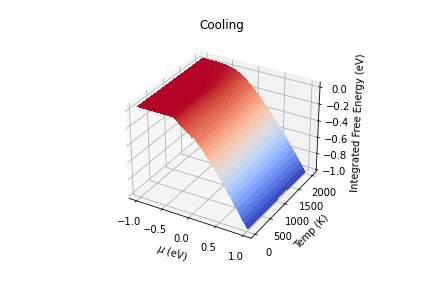

In [8]:
#plot the cooling free energy surfaces:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(cooling_chempot_grid, cooling_temperature_grid, cooling_integrated_free_energy, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_title("Cooling")
ax.set_xlabel("$\mu$ (eV)")
ax.set_ylabel("Temp (K)")
ax.set_zlabel("Integrated Free Energy (eV)")



In [9]:
graph_buffer = DiskBufferImage("graph","output.png","./")

def plot_dim(dim_name, fixed_dim, dp):
    ps = dp.get_parameter_space()
    xlabel(dim_name)

    for value in ps.get_dimension(fixed_dim).values:
        ps.get_parameter(fixed_dim).value = value
        plot(ps.get_parameter(dim_name).values, dp.get_slice("<formation_energy>", dim_name))
        plot(ps.get_parameter(dim_name).values, dp.get_slice("<formation_energy>", dim_name))

    legend(ps.get_dimension(fixed_dim).values)

    
    
figure(figsize=(12,4))
subplot(1,2, 1)
    
plot_dim("param_chem_pot(a)", "T", dp)
    
subplot(1,2, 2)
    
plot_dim("T", "param_chem_pot(a)", dp)



In [10]:
cooling_ps.get_dimension("param_chem_pot(a)").value=0.0
heating_ps.get_dimension("param_chem_pot(a)").value=0.0
def make_graph(chem_pot):
    print("T=",heating_ps.get_dimension("T").value)
    print("mu=",heating_ps.get_dimension("param_chem_pot(a)").value)
    print("T=",cooling_ps.get_dimension("T").value)
    print("mu=",cooling_ps.get_dimension("param_chem_pot(a)").value)
    E_heat = list(heating_dp.get_slice("integ_grand_free_energy","T"))
    E_cool = list(cooling_dp.get_slice("integ_grand_free_energy","T"))
    print(len(E_cool))
    fig2 = plt.figure()
    plt.scatter(heating_ps.get_dimension("T").values,E_heat,color='orange')
    plt.scatter(cooling_ps.get_dimension("T").values,E_cool,color='blue')
    #plt.scatter(b,a)
    plt.xlabel("Temp (K)")
    plt.ylabel("Integrated Free Energy (eV)")
    plt.title("$\mu$=%f,%f" % (cooling_ps.get_dimension("param_chem_pot(a)").value,heating_ps.get_dimension("param_chem_pot(a)").value))
    #plt.legend("heating","cooling")
    return fig2

def value_changed(value):
    cooling_ps.get_parameter("param_chem_pot(a)").value=heating_ps.get_parameter("param_chem_pot(a)").value
    imagedata = heating_ps.run_process(make_graph)
    graph_buffer.data = imagedata

heating_ps.get_parameter("param_chem_pot(a)").register_callback(value_changed)

In [11]:
##Debugging cell
#a = cooling_dp.get_slice("integ_grand_free_energy","T")
#b = cooling_dp.get_slice("T","param_chem_pot(a)")
#[i.id for i in cooling_ps.get_parameters()]
#print(b)
#heating_dp.list_fields()
#[i.id for i in heating_ps.get_parameters()]
#print(heating_integrated_free_energy.shape, cooling_integrated_free_energy.shape)
#print(cooling_integrated_free_energy-heating_integrated_free_energy)
#print(min(cooling_ps.get_dimension("T").values))

#heating_dp.get_slice("<comp_n(N)>","param_chem_pot(a)")[20]
#heating_ps.get_parameter("T").values

In [12]:

from ipywidgets import Button, HBox, VBox

box = VBox([heating_ps.get_parameter("param_chem_pot(a)").interactive_control(), graph_buffer.interactive_widget()])
graph_buffer._interactive_widget.width = "100%"
box

T= 20.0
mu= 0.0
T= 2000.0
mu= 0.0
100
0.0 0.0


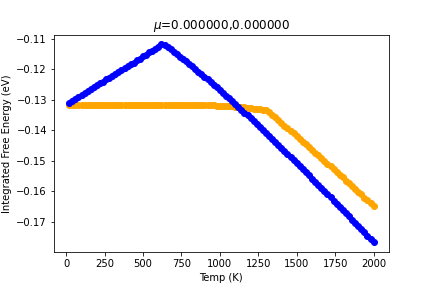

In [13]:
#cooling_ps.get_dimension("param_chem_pot(a)").values.index(0.0)
make_graph(cooling_ps.get_parameter("param_chem_pot(a)"))
print(heating_ps.get_parameter("param_chem_pot(a)").value,cooling_ps.get_parameter("param_chem_pot(a)").value)

# Extracting from configuration files

To extract a parameter space from configuration files, you must provide a data root directory and the name of the configuration file that can be found in subdirectories. This assumes all configuration file names are the same.

You will also need to describe how to extract the information from the configuration files. This is done by specifying the keys where the parameter data is found. For example if the configuration files look like:

```json
{
  "driver" : {
    "mode" : "incremental", 
    "motif" : {
      "configname" : "restricted_auto",
      "_configname" : "SCEL1_1_1_1_0_0_0/0",
      "_configdof" : "$HOME/laptop_share/NbO_rocksalt_gs/mc_runs/fit_13.02/coarse_grid/set2_cooling_grid2/A_3.9B_-19.1/conditions.298/tto/final_state.json"
    },
    "initial_conditions" : {
      "param_chem_pot" : {
        "a" : 3.90,
        "b" : -19.80
      },
      "temperature" : 20.0,
      "tolerance" : 0.001
    },
    "final_conditions" : {
      "param_chem_pot" : {
        "a" : 3.90,
        "b" : -19.80
      },
      "temperature" :2800.0,
      "tolerance" : 0.001
    },
    "incremental_conditions" : {
      "param_chem_pot" : {
        "a" : 0.0,
        "b" : 0.0
      },
      "temperature" : 10.0,
      "tolerance" : 0.001
    }
  }
}

```

You specify the starting value key as: ```driver/initial_conditions/*``` because the starting values are a list within the "driver" and " initial_conditions" keys. A similar string needs to be constructed for end and increment keys.


Current limitations:
  * JSON only
  * space must be described by its boundaries and the incremement
  * Limited format to describe how to extract the information. Currently values must be leaf nodes.

TODO... Ignore below...